In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sns

from causalgraphicalmodels import CausalGraphicalModel
from matplotlib import gridspec
from matplotlib import pylab as plt
from scipy import stats

In [2]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")

# Chapter 6 - THE HAUNTED DAG & THE CAUSAL TERROR

## End of Chapter Problems

### 6E1.



List three mechanisms by which multiple regression can produce false inferences about causal effects

#### Answer

1) Collider bias, by conditioning inappropriately on some variables.

2) Omitted variable bias occurs when certain variables are erroneously not used as predictor variables in our models. This could cause you to fall victim to spurious associations in the model in a multiple regression.

3) Post treatment bias can obscure the actual degree to which a treatment actually impacts and outcome. This occurs because we can end up conditioning on some mediating variable which is part of the mechanism through which the treatment operates. When stated in the correct way, these fallacies can seem obviously stupid. Eg, I want to know how much antibiotics stop me from dying from an infection. I then control for pathogen levels in the blood. I observe that once I've controlled for pathogen levels in the blood, anti-biotics show no association with dying from infection. But reducing pathogen levels is precisely the mechanism through which the anti-biotic operates.

4) Multicollinearities between predictor variables can also lead us astray.

### 6E2.

For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.

#### Answer

For a very topical example of this problem see this paper: 

$\textit{Collider bias undermines our understanding of COVID-19 disease risk and severity}$

https://www.nature.com/articles/s41467-020-19478-2

### 6E3.

List the four elemental confounds. Can you explain the conditional dependencies of each?

#### Answer

The fork, the collider, the pipe, and the descendant.

##### The Fork

X <- Z -> Y

Conditioned on the Z, X and Y should be independent of one another

##### The Collider

X -> Z <- Y

X and Y are already independent of one another, but conditioning on Z will induce a spurious association

##### The Pipe
X -> Y -> Z

X and Z are independent conditional on Z.

##### The Descendent

(See fig Below)

X and Z are independent of one another. However, conditioning on the D, the descendant of Y will induce a relationship between X and Z removing their conditional independence. This is because D contains information about Y, so conditioning on it is will inform us roughly what Y is. This will in turn produce a collider bias between X and Z

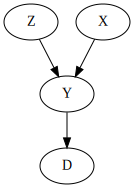

In [3]:
Dag = CausalGraphicalModel(
    nodes=["X","Y","Z","D"],
    edges=[
        ("X","Y"),
        ("Z", "Y"),
        ("Y","D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

### 6E4.

How is a biased sample like conditioning on a collider? Think of the example at the open of the chapter

#### Answer

(The paper referenced above give more details about this)

Biased samples can be produced in many ways, but often they have the characteristic of being like the selection distortion criterion. Eg, think of a study looking into health and IQ. Instead of uniformly sampling the whole population to get subjects for the study, instead what you do is go and sample military personnel, because they won't drop out of the study over a one year period like pesky civilians. This would obviously a biased sample. Why? Because one could plausibly imagine that in order to enter the military one needs to have some combination of physical attributes and IQ. If you are moderately unhealthy, but have a very high IQ, perhaps you can enter one of the intelligence divisions, whilst if you possess a low IQ and possess good health you could enter a more physically, but less cognitively demanding roll.

Let's call the sample group G, which is a random variable whose sample space is all possible partitions of the general population, one element of which is the military. The reason this is an example of collider bias is that the two variables of interest X and Y determine which group you belong to, and whether you are in fact capable of being a member of certain groups, like the military. Thus conditioning on group, or your biased sample will induce a spurious relationship among the variables you're interested in. This is represented in the DAG below by showing that IQ and H determine your probability of being in a sample group, biasing your sample and your study.

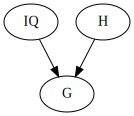

In [4]:
Dag = CausalGraphicalModel(
    nodes=["IQ","H","G"],
    edges=[
        ("IQ","G"),
        ("H", "G")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Dag.draw()

One could imagine (rather implausibly) that the pool of people who apply to be in the military is a uniform sample of the population, for which there may (again, perhaps implausibly) be no relationship between IQ and health. If this were so, one could perform the study in military applicants as they would be a representative, unbiased sample of the population. 

But in all likelihood, once you condition on actually being in the military, you induce a spurious correlation between health and IQ, just through the selection distortion effect. We can visualise this below where there's some strange metric of health and IQ, and some combination of these two is required to get into the military.

In [5]:
X = np.random.uniform(0, 10, size=70)
Y = np.random.uniform(0, 10, size=70)
Z = X+Y
x = np.linspace(0, 10)
y = 12 - x

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


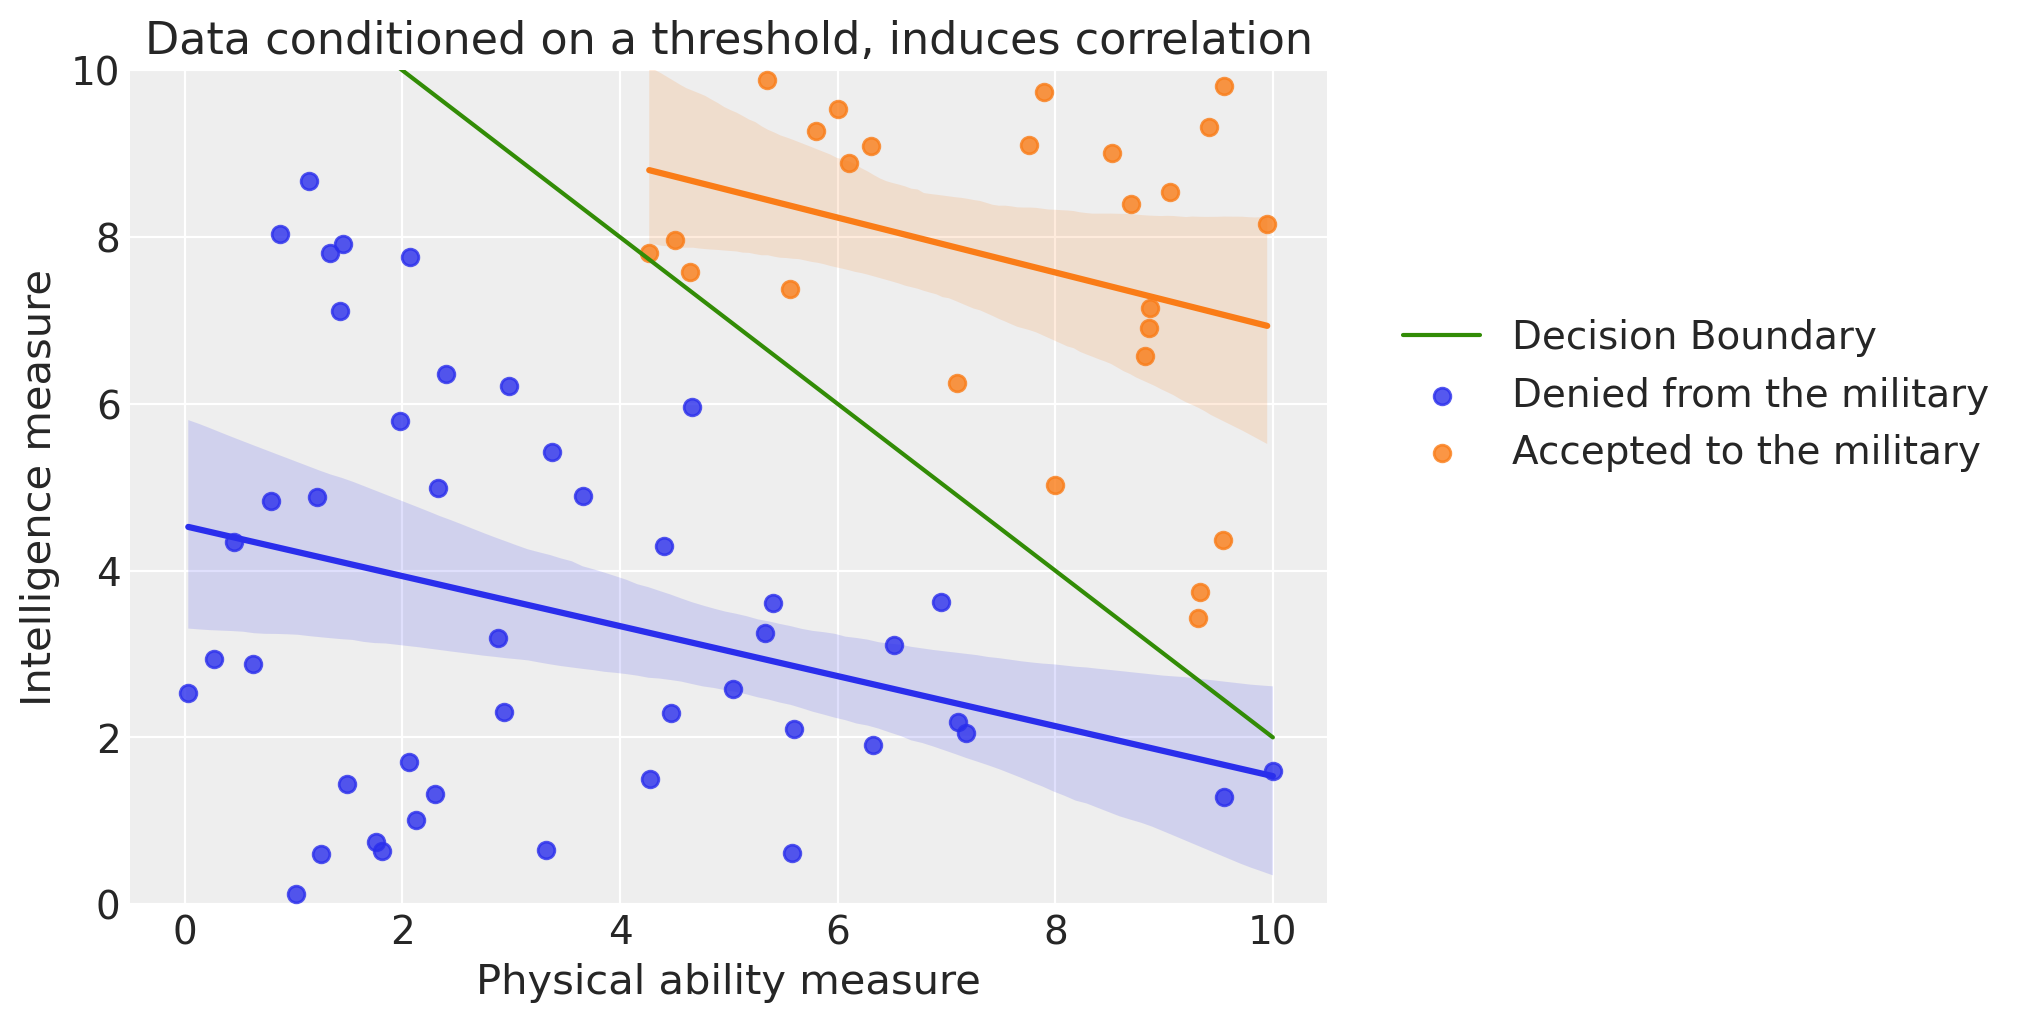

In [6]:
fig = plt.subplots(1,1,figsize=(10,5))
sns.regplot(X[Z<=12],Y[Z<=12],label="Denied from the military")
sns.regplot(X[Z>12],Y[Z>12], label="Accepted to the military")
plt.plot(x,y, label="Decision Boundary")
plt.ylim(0,10)
plt.xlabel("Physical ability measure")
plt.ylabel("Intelligence measure")
plt.legend(loc=(1.05,0.5))
plt.title("Data conditioned on a threshold, induces correlation");

### 6M1.
Modify the DAG on page 186 to include the variable V, an unobserved cause of C and Y: C ← V → Y. Reanalyze the DAG. How many paths connect X to Y? Which must be closed? Which
variables should you condition on now?

#### Answer

Below is a horribly rendered version of the DAG found in the text with the V variable included in it.

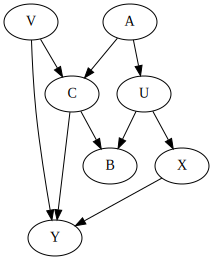

In [7]:
M1Dag = CausalGraphicalModel(
    nodes=["A", "B", "C", "U", "X", "Y", "V"],
    edges=[
        ("A", "C"),
        ("A", "U"),
        ("U", "B"),
        ("C", "B"),
        ("C", "Y"),
        ("U", "X"),
        ("X", "Y"),
        ("V", "C"),
        ("V", "Y")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
M1Dag.draw()

In [8]:
M1Dag.get_all_backdoor_paths("X", "Y")

[['X', 'U', 'A', 'C', 'Y'],
 ['X', 'U', 'A', 'C', 'V', 'Y'],
 ['X', 'U', 'B', 'C', 'Y'],
 ['X', 'U', 'B', 'C', 'V', 'Y']]

In [9]:
# get the set of all backdoor adjustments between X and Y
M1Dag.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'B', 'C', 'V'}),
           frozenset({'U'}),
           frozenset({'A', 'C', 'U', 'V'}),
           frozenset({'B', 'U'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'B', 'C', 'U', 'V'}),
           frozenset({'A'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'A', 'B', 'U', 'V'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'A', 'U'}),
           frozenset({'C', 'U'}),
           frozenset({'A', 'C'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'A', 'B', 'C', 'V'}),
           frozenset({'A', 'B', 'C', 'U'}),
           frozenset({'U', 'V'}),
           frozenset({'C', 'U', 'V'}),
           frozenset({'A', 'U', 'V'}),
           frozenset({'C', 'V'}),
           frozenset({'A', 'V'}),
           frozenset({'A', 'C', 'V'}),
           frozenset({'B', 'U', 'V'}),
           frozenset({'A', 'B', 'C', 'U', 'V'})})

There are now 5 paths from X to Y.
(1) X ← U ← A → C → Y

(2) X ← U → B ← C → Y← V

(3) X ← U ← A → C ← V →Y

(4) X ← U → B ← C ← V → Y

(5) X → Y


### 6M2.
Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among
predictors before including them in a model. This is a bad procedure, because what matters is the
conditional association, not the association before the variables are included in the model. To highlight this, consider the DAG X → Z → Y. Simulate data from this DAG so that the correlation
between X and Z is very large. Then include both in a model prediction Y. Do you observe any
multicollinearity? Why or why not? What is different from the legs example in the chapter?


In [10]:
# simulate data according to the DAG
x = np.random.normal(size=100)
z = np.random.normal(loc=4*x)
y = np.random.normal(loc=1*z)

In [11]:
def standardize(x): return (x - np.mean(x))/np.std(x)

In [12]:
# standardise the data
sx, sy, sz = standardize(x), standardize(y), standardize(z)
data = pd.DataFrame(np.array([sx, sy, sz]).T, columns=["sx", "sy", "sz"])
data.corr()  # get the correlation matrix

,sx,sy,sz
sx,1.000000,0.948067,0.974381
sy,0.948067,1.000000,0.974894
sz,0.974381,0.974894,1.000000


In [13]:
# predict y with both x and z as predictors
with pm.Model() as pipe:
    a = pm.Normal("a", mu=0, sd=0.2)
    bx = pm.Normal("bx", mu=0, sd=0.5)
    bz = pm.Normal("bz", mu=0, sd=0.5)
    mu = a + bx*sx + bz*sz
    sigma = pm.Exponential("sigma", 5)
    y = pm.Normal("y", mu=mu, sd=sigma, observed=sy)
    sample = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bz, bx, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 6 seconds.


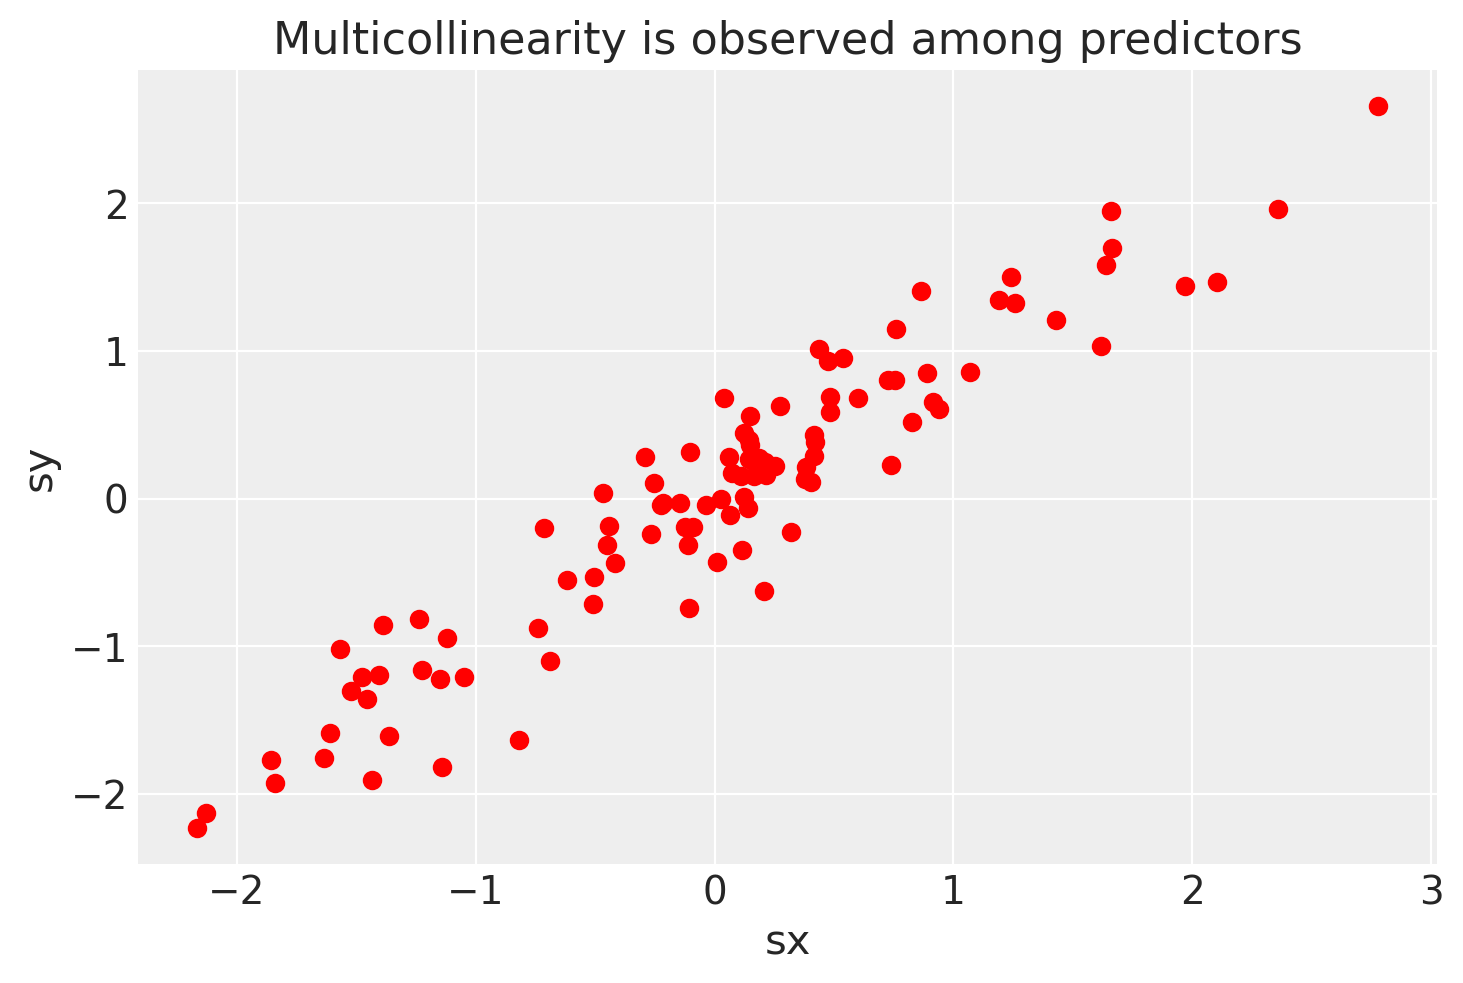

In [14]:
fig, ax = plt.subplots(1,1)
ax.scatter(sx, sy, c="r")
ax.set_xlabel("sx")
ax.set_ylabel("sy")
ax.set_title("Multicollinearity is observed among predictors");

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


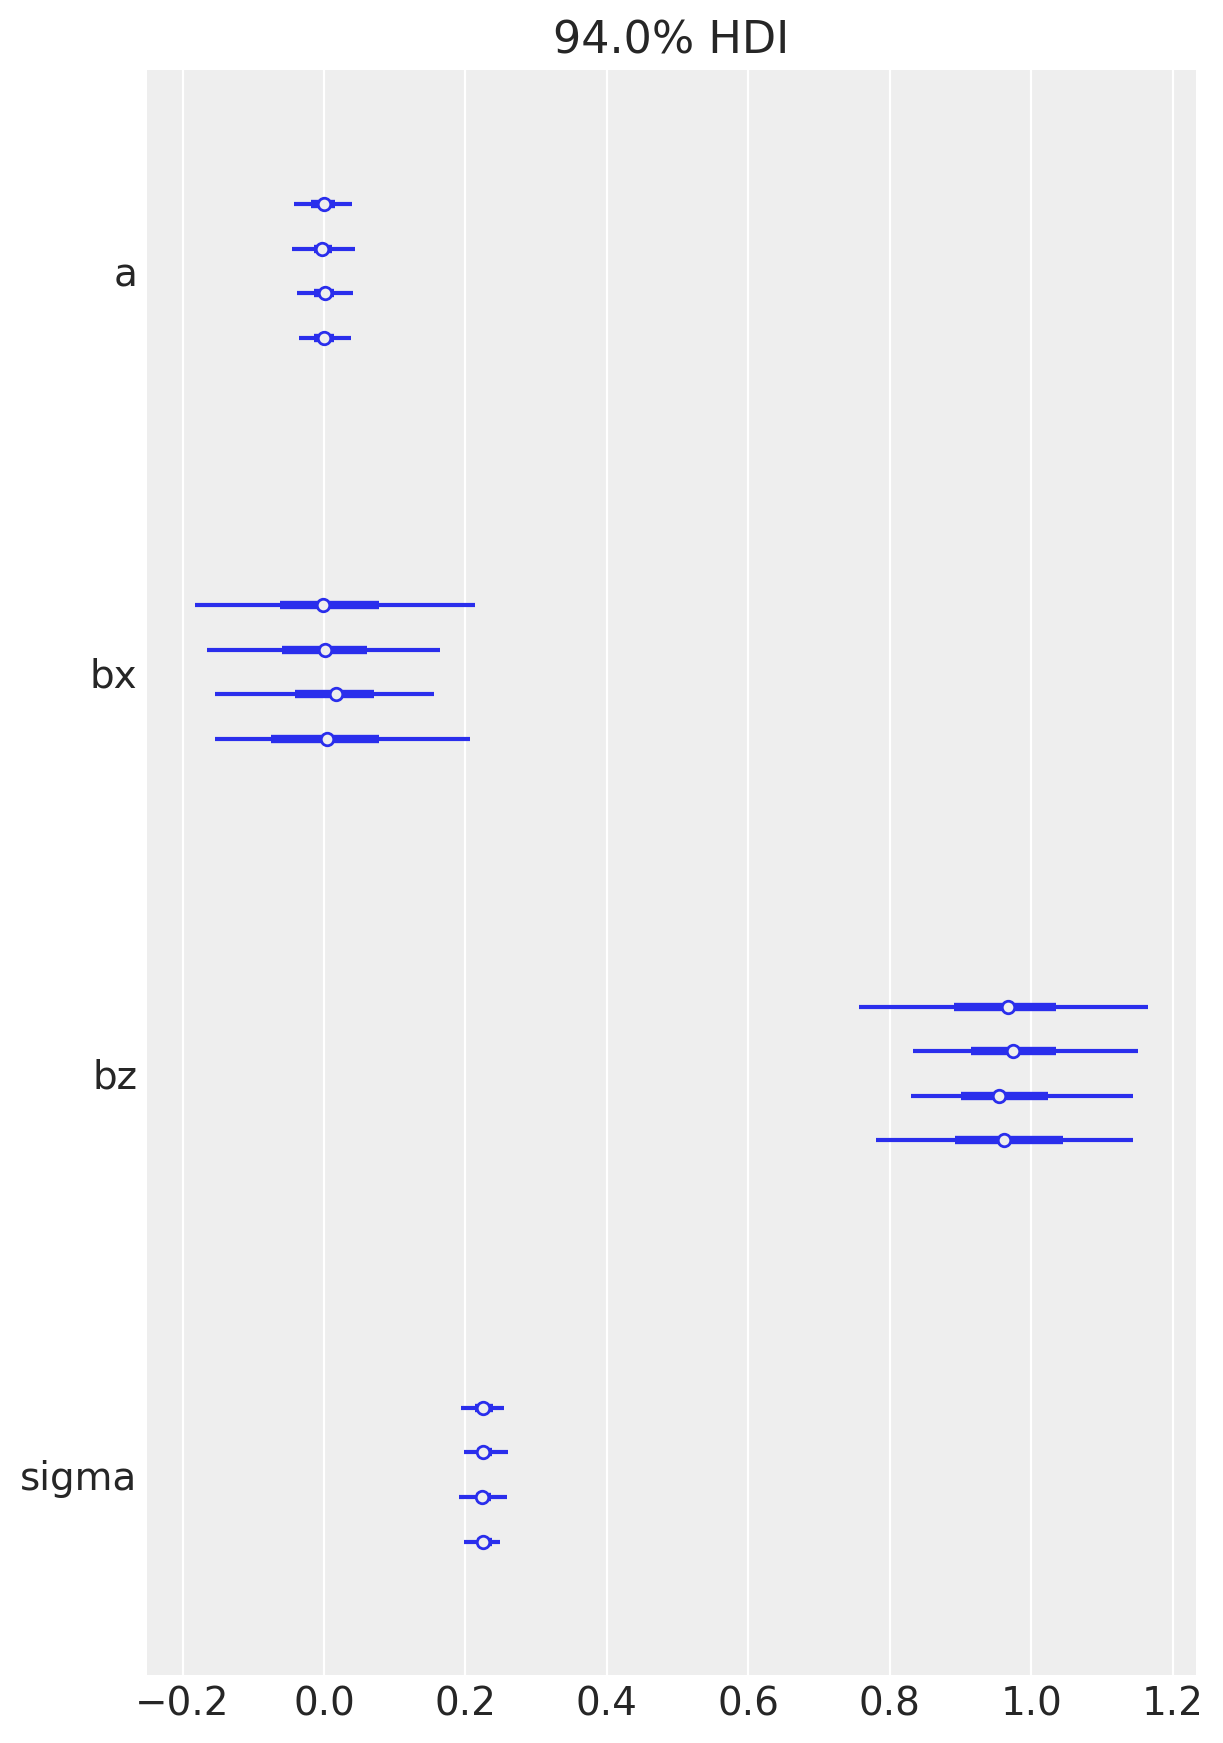

In [15]:
az.plot_forest(sample);

In [16]:
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.022,-0.041,0.042,0.001,0.001,743.0,279.0,786.0,506.0,1.01
bx,0.004,0.097,-0.166,0.195,0.005,0.003,416.0,416.0,415.0,571.0,1.00
bz,0.969,0.097,0.796,1.147,0.005,0.003,420.0,420.0,417.0,582.0,1.01
sigma,0.227,0.018,0.197,0.260,0.001,0.000,648.0,636.0,649.0,562.0,1.01


Multicollinearity is observed in this data set, because Z was produced from X. This is different to the leg example where the two predictor variables were produced by a third confounding variable. In this case however collinearity was induced by the causal effect and not by an unobserved confounder as in the leg and milk examples in the book. In this case it's because Z mediates the effect of X. When you control for both effects, it can be seen that the effect of X on Y goes to zero, which is precisely what you should expect from a pipe.

### 6M3.
Learning to analyze DAGs requires practice. For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of X on Y.

#### Answer 


Top left, control for Z

Top right, control for nothing

Bottom left, control for nothing

Bottom right, control for A

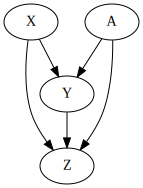

In [17]:
M2Dag = CausalGraphicalModel(
    nodes=["A", "Z", "X", "Y"],
    edges=[
        ("X", "Y"),
        ("X", "Z"),
        ("Y", "Z"),
        ("A", "Z"),
        ("A", "Y")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
M2Dag.draw()

In [18]:
# get the set of all backdoor adjustments between X and Y
M1Dag.get_all_backdoor_adjustment_sets("X", "Y")

frozenset({frozenset({'B', 'C', 'V'}),
           frozenset({'U'}),
           frozenset({'A', 'C', 'U', 'V'}),
           frozenset({'B', 'U'}),
           frozenset({'B', 'C', 'U'}),
           frozenset({'B', 'C', 'U', 'V'}),
           frozenset({'A'}),
           frozenset({'A', 'B', 'U'}),
           frozenset({'A', 'B', 'U', 'V'}),
           frozenset({'A', 'B', 'C'}),
           frozenset({'A', 'U'}),
           frozenset({'C', 'U'}),
           frozenset({'A', 'C'}),
           frozenset({'A', 'C', 'U'}),
           frozenset({'A', 'B', 'C', 'V'}),
           frozenset({'A', 'B', 'C', 'U'}),
           frozenset({'U', 'V'}),
           frozenset({'C', 'U', 'V'}),
           frozenset({'A', 'U', 'V'}),
           frozenset({'C', 'V'}),
           frozenset({'A', 'V'}),
           frozenset({'A', 'C', 'V'}),
           frozenset({'B', 'U', 'V'}),
           frozenset({'A', 'B', 'C', 'U', 'V'})})

### 6H1.
Use the Waffle House data, data(WaffleDivorce), to find the total causal influence of number of Waffle Houses on divorce rate. Justify your model or models with a causal graph.

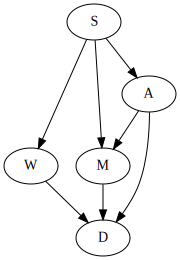

In [19]:
Waffle = CausalGraphicalModel(
    nodes=["S", "M", "W", "A", "D"],
    edges=[
        ("S", "W"),
        ("S", "M"),
        ("S", "A"),
        ("A", "M"),
        ("A", "D"),
        ("M", "D"),
        ("W", "D")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Waffle.draw()

In [20]:
data = pd.read_csv("./data/WaffleDivorce.csv", delimiter=";")

We can take the DAG from the book and actually run it to see if DAG W is independent of D once we have conditioned on whether a state is in the South or not. By using the backdoor principle, we can figure out the total causal effect of W on D by conditioning on S.

In [21]:
# standardise the data
sw, sd = standardize(data.WaffleHouses), standardize(data.Divorce)

<ipython-input-22-94339249f05b>:22: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout();


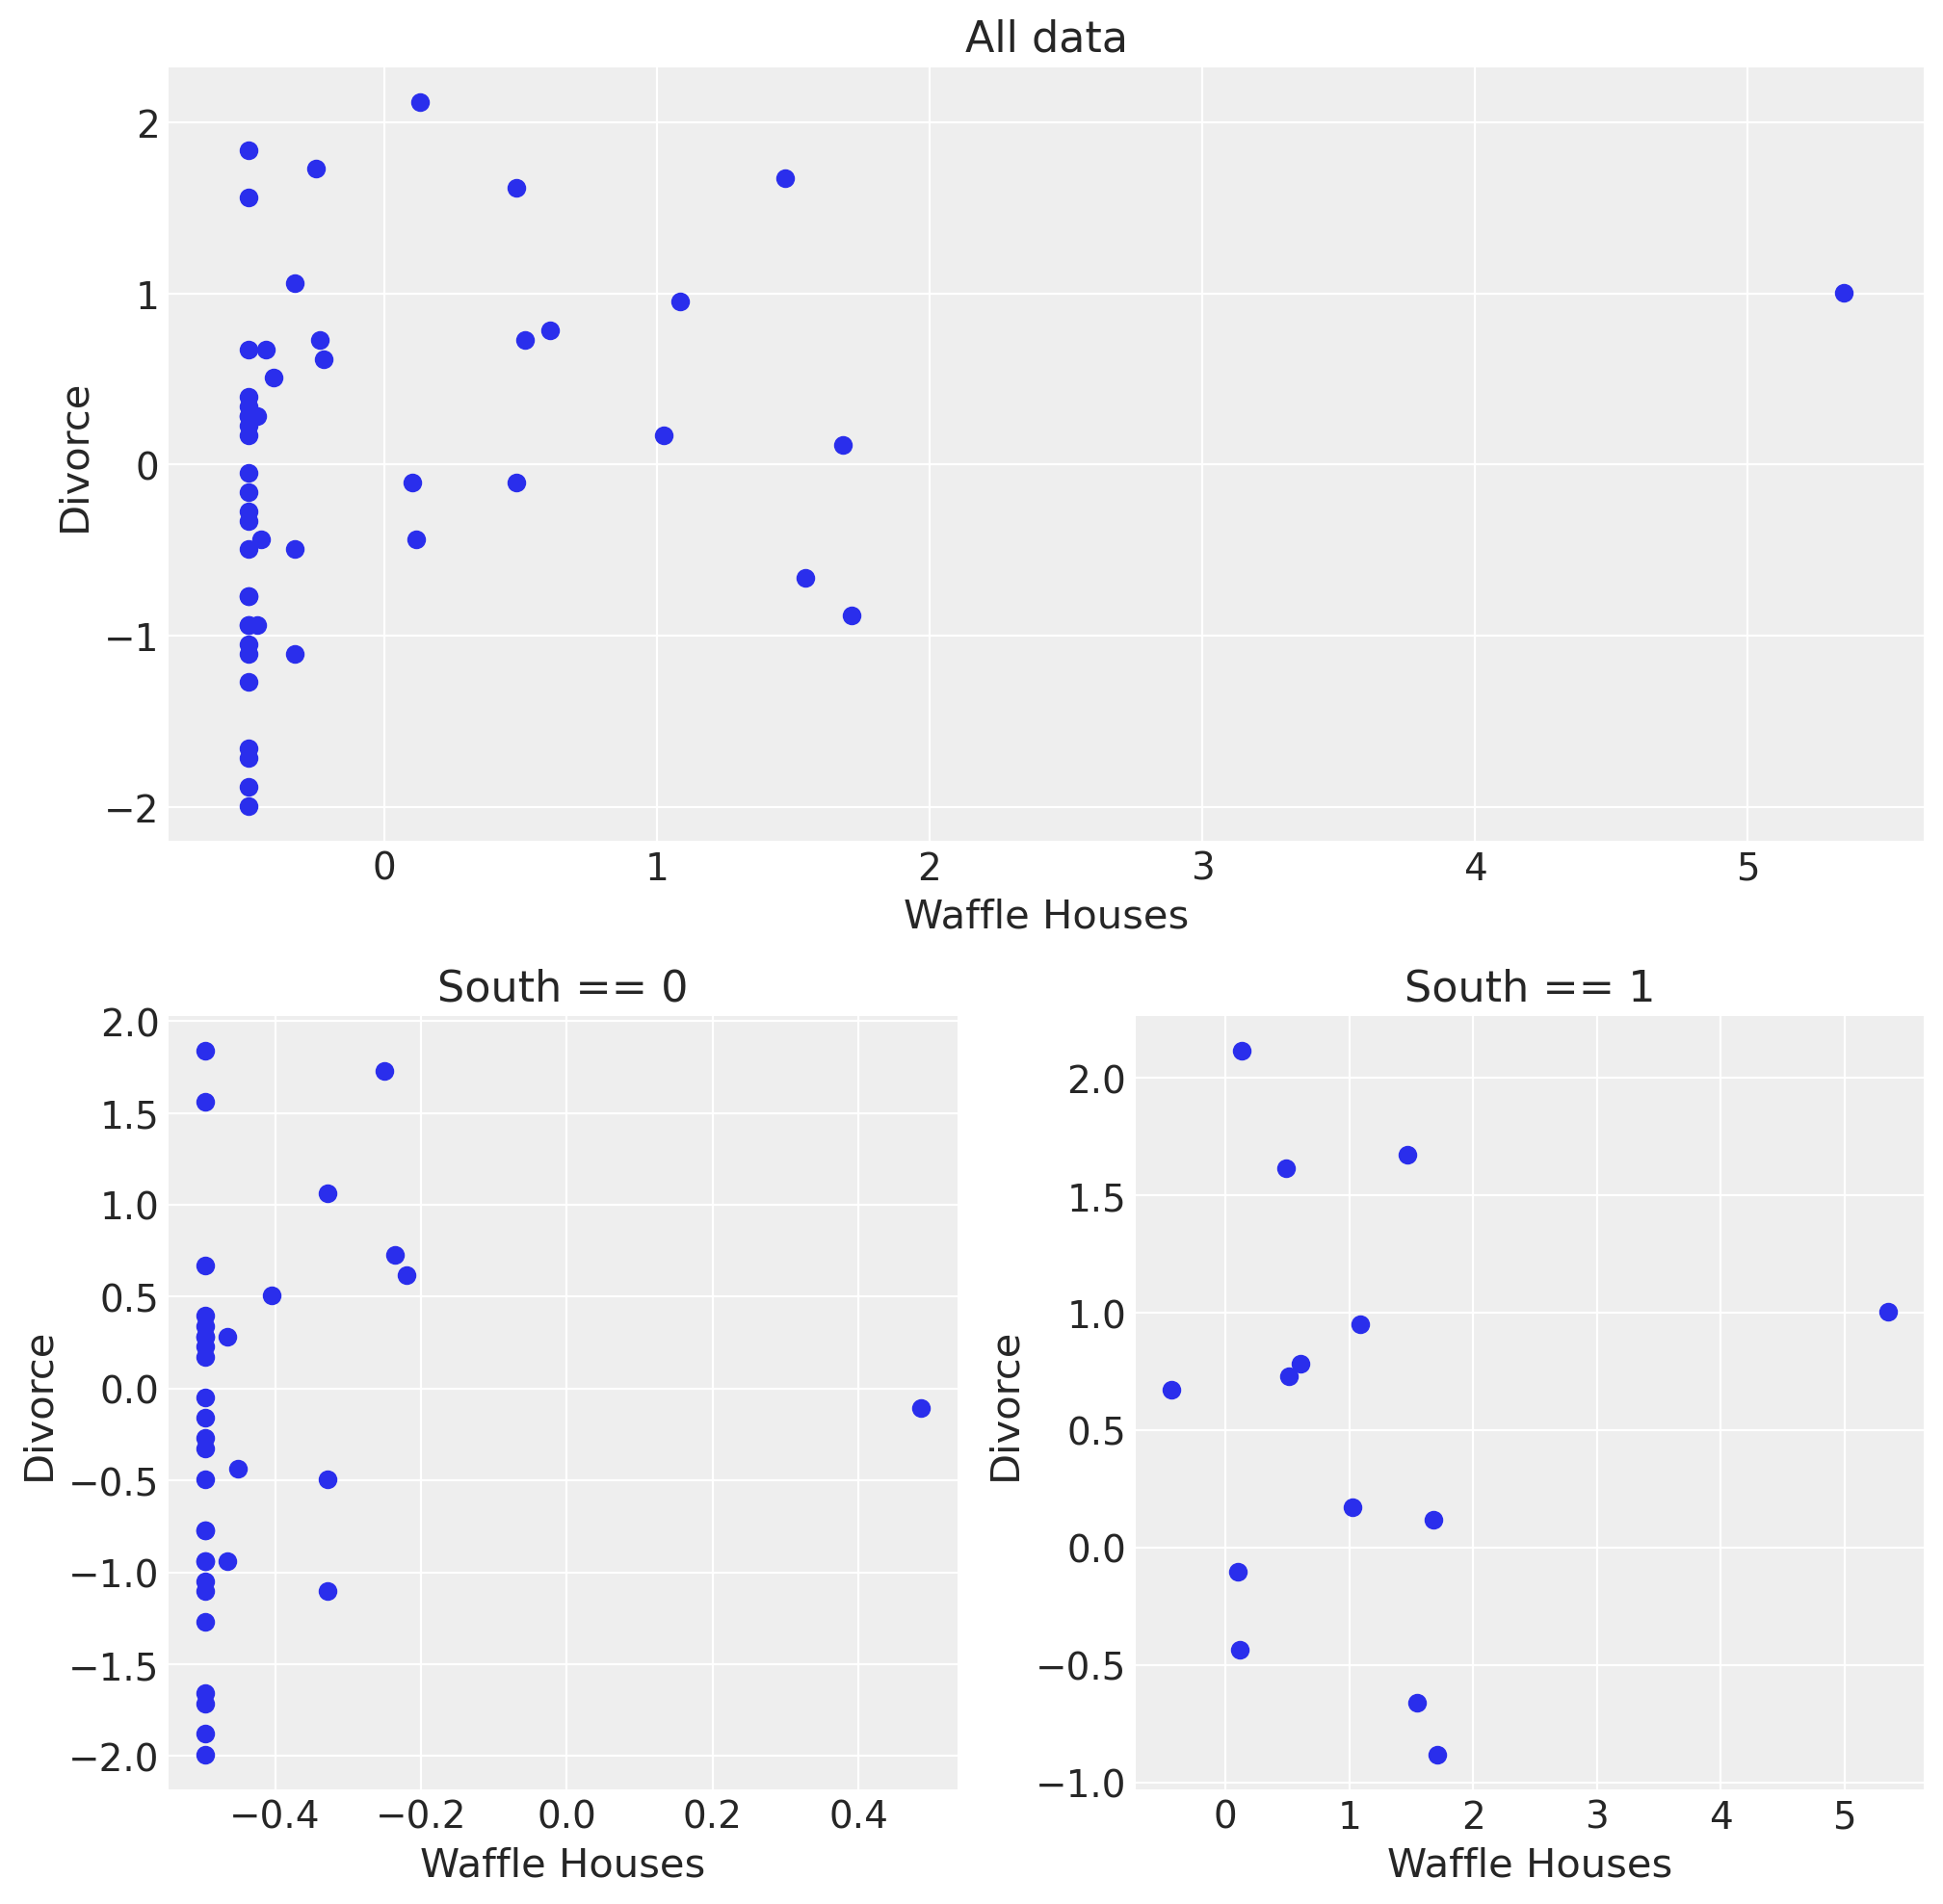

In [22]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2)

ax0 = fig.add_subplot(gs[0, :])
ax0.scatter(sw, sd)
ax0.set_xlabel("Waffle Houses")
ax0.set_ylabel("Divorce")
ax0.set_title("All data")

ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(sw[data.South == 0], sd[data.South == 0])
ax1.set_title("South == 0")
ax1.set_xlabel("Waffle Houses")
ax1.set_ylabel("Divorce")

ax2 = fig.add_subplot(gs[1, 1])
ax2.scatter(sw[data.South == 1], sd[data.South == 1])
ax2.set_title("South == 1")
ax2.set_xlabel("Waffle Houses")
ax2.set_ylabel("Divorce")

fig.tight_layout();

We can use pymc3 to perform the regression conditioned on whether each state is in the south of not.

In [23]:
# Regression for all the data
with pm.Model() as Waffle_Model:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    mu = a + b*sw
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sd)
    sample = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.


In [24]:
az.summary(sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.006,0.118,-0.227,0.226,0.003,0.004,1281.0,452.0,1283.0,491.0,1.01
b,0.234,0.134,-0.038,0.460,0.004,0.003,940.0,933.0,943.0,583.0,1.00
sigma,1.003,0.104,0.807,1.194,0.003,0.002,1062.0,1029.0,1065.0,781.0,1.00


In [25]:
# Regression for the categorical variables
with pm.Model() as Waffle_south:
    a = pm.Normal("a", mu=0, sd=0.2, shape=2)
    b = pm.Normal("b", mu=0, sd=0.5, shape=2)
    mu = a[data["South"]] + b[data["South"]]*sw
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sd)
    sample_south = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 3 seconds.


In [26]:
az.summary(sample_south)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a[0],-0.040,0.156,-0.313,0.265,0.005,0.005,832.0,573.0,829.0,752.0,1.0
a[1],0.145,0.170,-0.158,0.466,0.006,0.005,946.0,696.0,947.0,658.0,1.0
b[0],0.340,0.346,-0.293,0.993,0.012,0.009,867.0,750.0,872.0,763.0,1.0
b[1],0.126,0.161,-0.164,0.423,0.006,0.004,802.0,721.0,802.0,826.0,1.0
sigma,0.988,0.104,0.789,1.164,0.003,0.002,1112.0,1069.0,1164.0,761.0,1.0


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packag

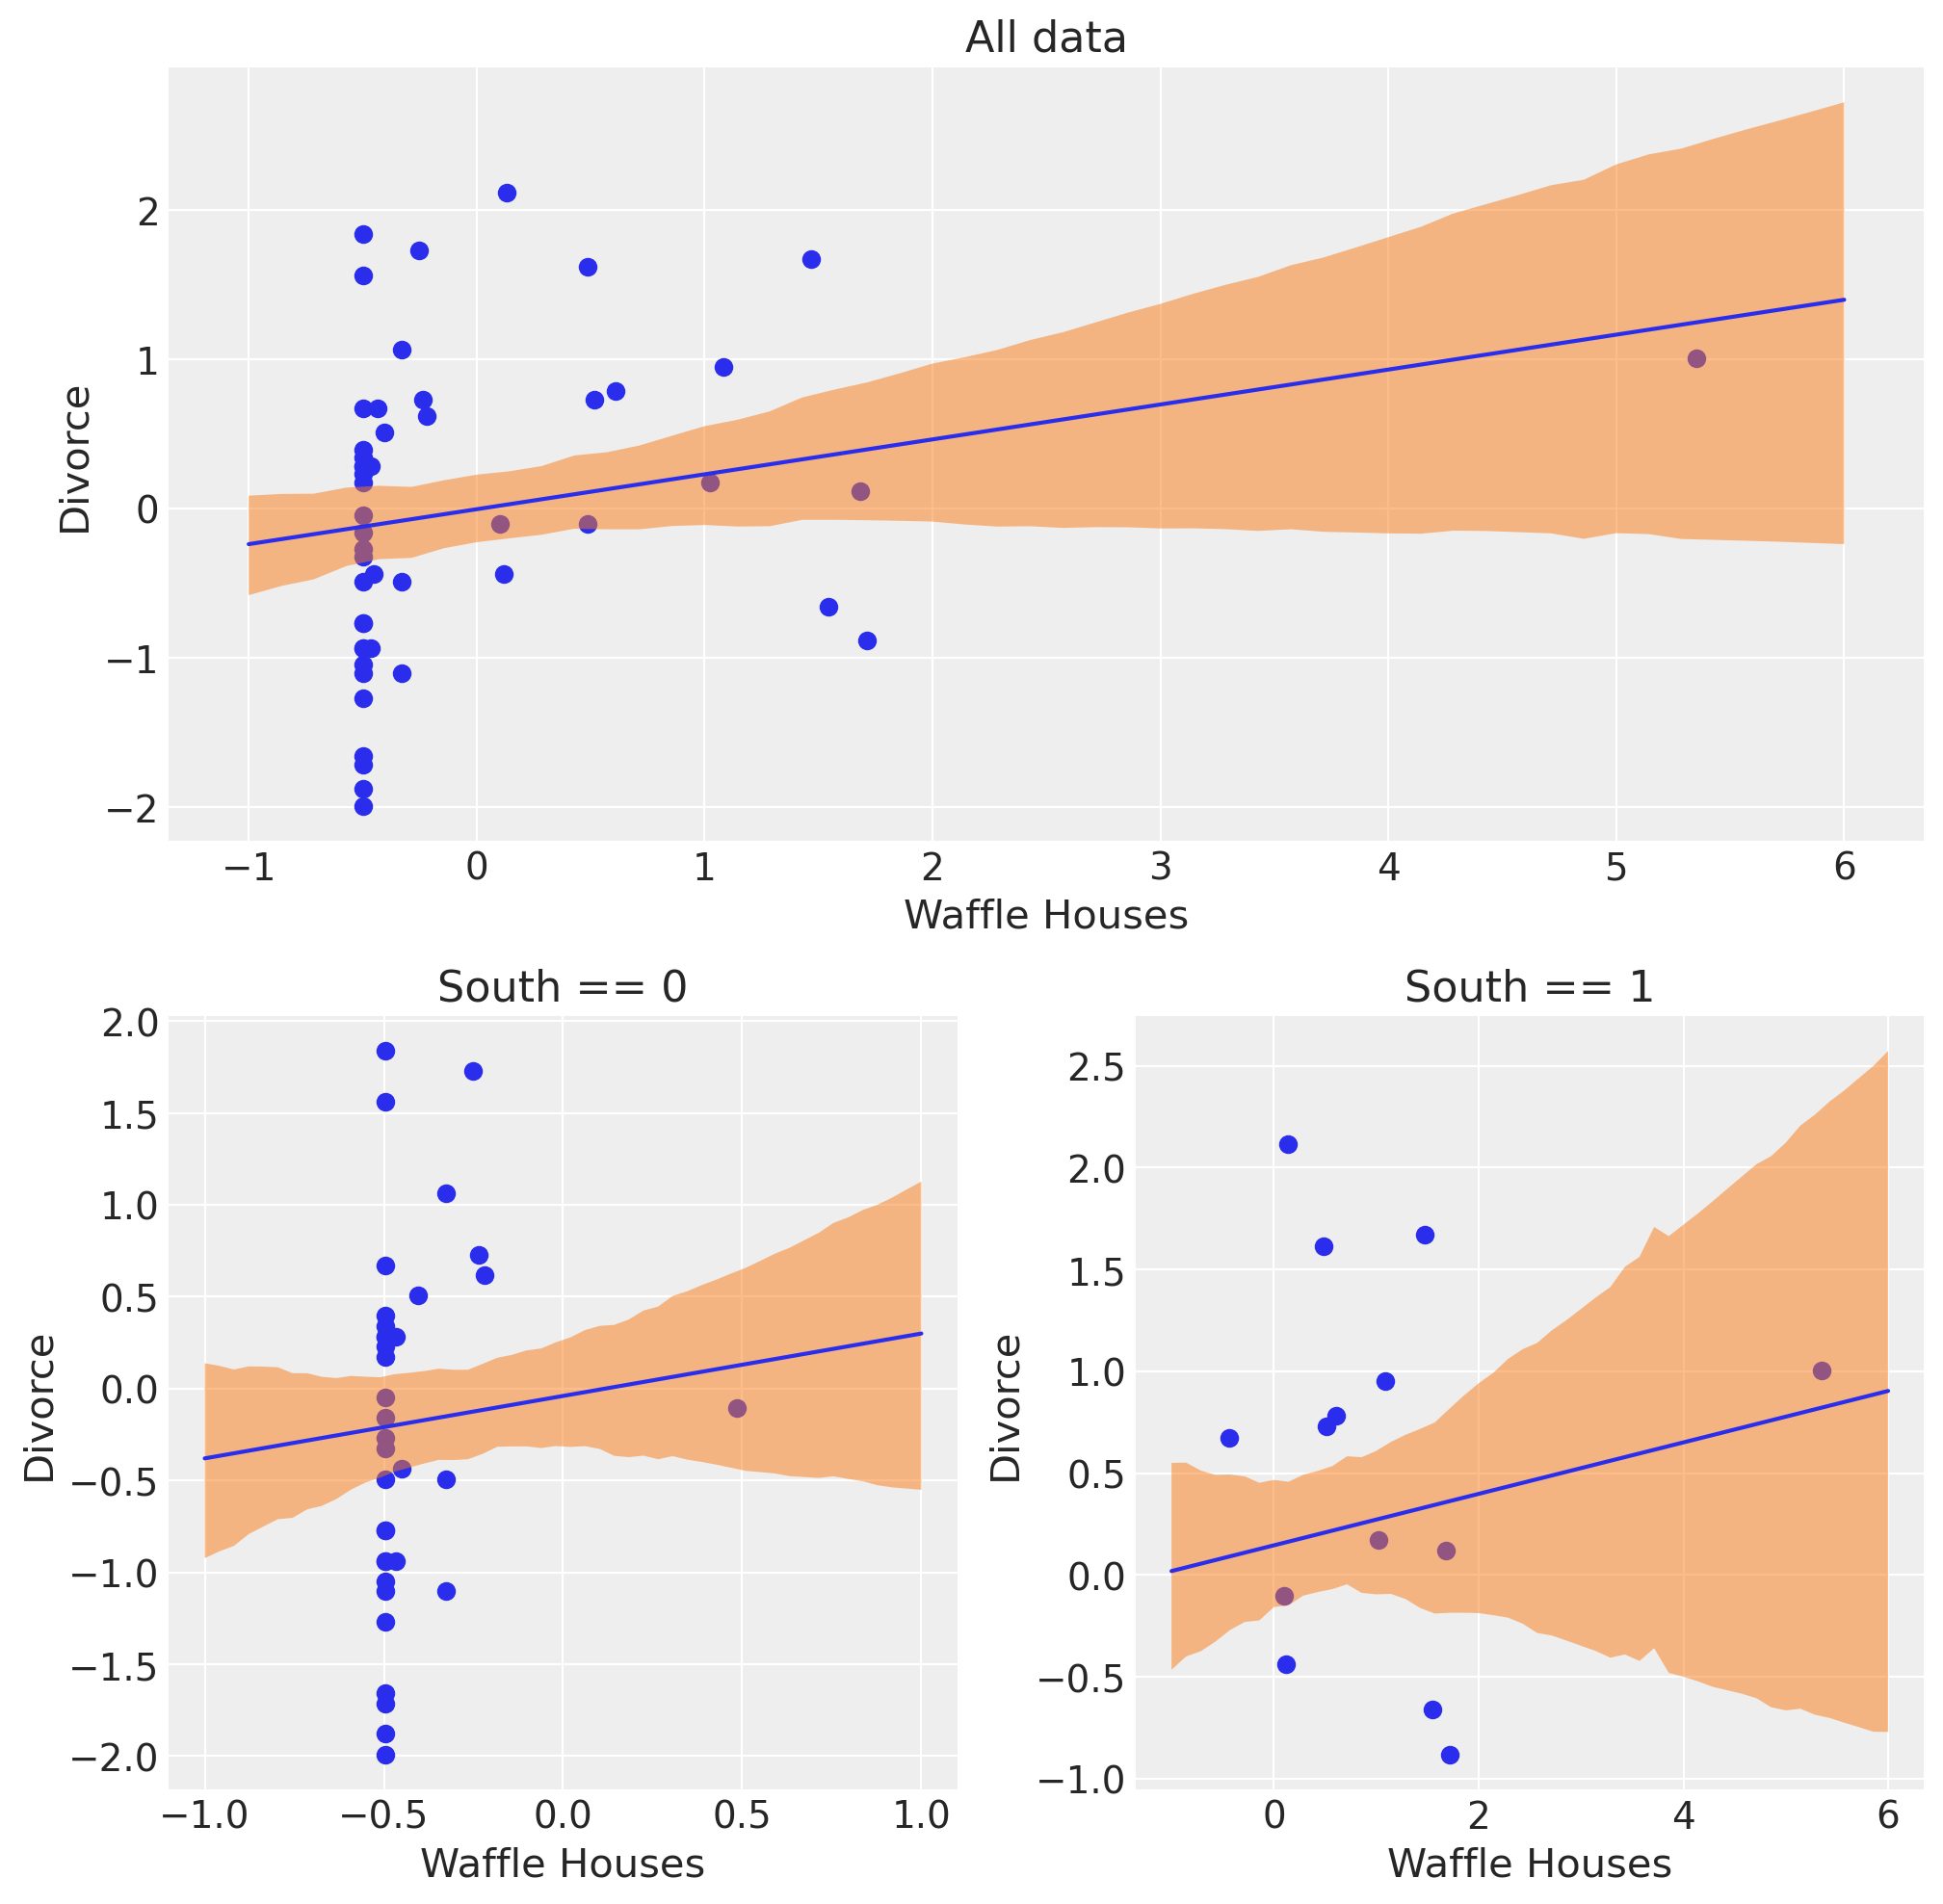

In [27]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 2)


"""
Total data fit
"""

x = np.linspace(-1, 6)
post_total = sample["a"] + np.outer(x, sample["b"])
interval = pm.hpd(post_total.T)

ax0 = fig.add_subplot(gs[0, :])
ax0.scatter(sw, sd)
ax0.fill_between(x, interval[:, 0], interval[:, 1], alpha=0.5)
ax0.plot(x, np.mean(post_total, axis=1))
ax0.set_xlabel("Waffle Houses")
ax0.set_ylabel("Divorce")
ax0.set_title("All data")


"""
North data fit
"""
x = np.linspace(-1, 1)
post_North = sample_south["a"][:, 0] + np.outer(x, sample_south["b"][:, 0])
interval = pm.hpd(post_North.T)
ax1 = fig.add_subplot(gs[1, 0])
ax1.scatter(sw[data.South == 0], sd[data.South == 0])
ax1.plot(x, np.mean(post_North, axis=1))
ax1.fill_between(x, interval[:, 0], interval[:, 1], alpha=0.5)
ax1.set_title("South == 0")
ax1.set_xlabel("Waffle Houses")
ax1.set_ylabel("Divorce")

"""
South data fit
"""
x = np.linspace(-1, 6)
post_South = sample_south["a"][:, 1] + np.outer(x, sample_south["b"][:, 1])
interval = pm.hpd(post_South.T)
ax2 = fig.add_subplot(gs[1, 1])
ax2.scatter(sw[data.South == 1], sd[data.South == 1])
ax2.plot(x, np.mean(post_South, axis=1))
ax2.fill_between(x, interval[:, 0], interval[:, 1], alpha=0.5)
ax2.set_title("South == 1")
ax2.set_xlabel("Waffle Houses")
ax2.set_ylabel("Divorce")

fig.tight_layout();

The top figure shows the posterior fit for a single predictor value. This shows a correlation between #waffle houses in a state and divorce. When we condition on whether the state is in the South however, it can be seen that the predictive power of the number of Waffles becomes more consistent with zero. We can visualise posterior distribution for the effect size of #waffles in Southern states vs Northern.

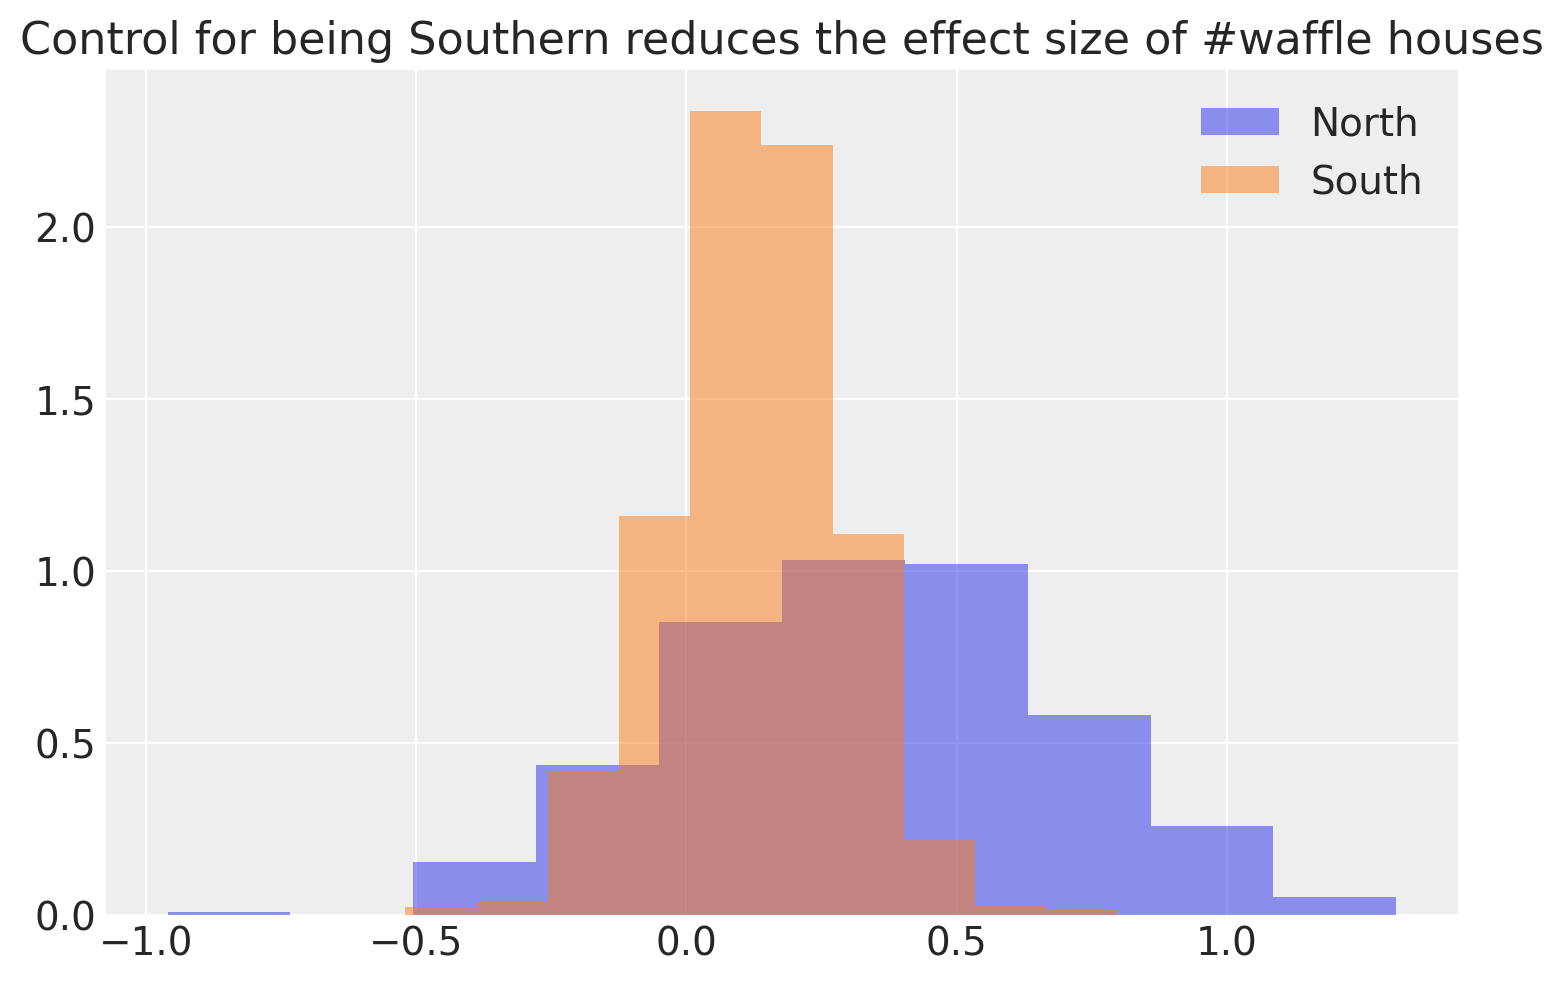

In [28]:
plt.title("Control for being Southern reduces the effect size of #waffle houses")
plt.hist(sample_south["b"][:, 0], density=True, alpha = 0.5, label = "North")
plt.hist(sample_south["b"][:, 1], density=True, alpha = 0.5, label= "South")
plt.legend();

We can sample from the posteriors in accordance with the number of samples in the data

In [29]:
ps = data.South.sum()/data.shape[0]

In [30]:
ps

0.28

In [31]:
Nor = np.random.choice(sample_south["b"][:, 0], size=int(1000*ps))
Sou = np.random.choice(sample_south["b"][:, 1], size=int(1000*(1-ps)))

In [32]:
total_eff = np.concatenate([Nor, Sou])

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)


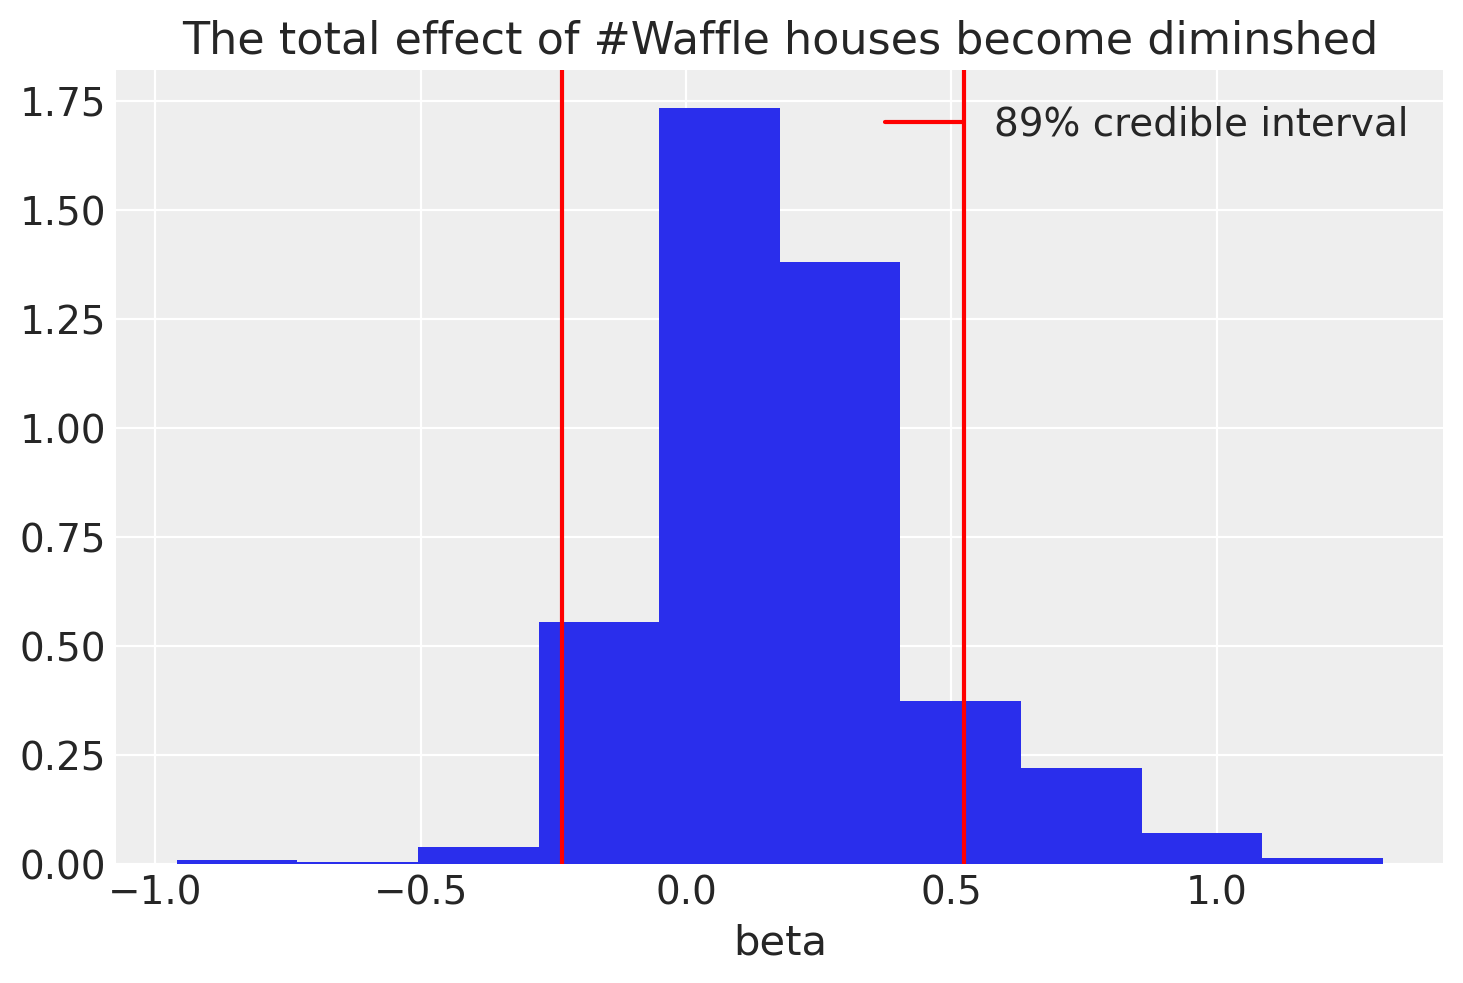

In [33]:
plt.title("The total effect of #Waffle houses become diminshed")
plt.hist(total_eff, density=True)
plt.axvline(pm.hpd(total_eff, hdi_prob=0.89)[
            0], c="r", label="89% credible interval")
plt.axvline(pm.hpd(total_eff, hdi_prob=0.89)[1], c="r")
plt.xlabel("beta")
plt.legend()
plt.show()

In [34]:
pm.hpd(total_eff, hdi_prob=0.89)

array([-0.23460593,  0.52344658])

This is consistent with there being no effect once the state being in the South or not has been controlled for.

### 6H2.

Build a series of models to test the implied conditional independencies of the causal graph you used in the previous problem. If any of the tests fail, how do you think the graph needs to be amended? Does the graph need more or fewer arrows? Feel free to nominate variables that aren’t in the data

#### Answer 
You can think hard about this and look for the implied independencies yourself. Alternatively software can help out with finding the implied conditional independencies of your model.


In [35]:
Waffle.get_all_independence_relationships()

[('S', 'D', {'A', 'M', 'W'}),
 ('W', 'M', {'S'}),
 ('W', 'M', {'A', 'S'}),
 ('W', 'A', {'S'}),
 ('W', 'A', {'M', 'S'})]

Let's test one of these to illustrate the point. ('A', 'W', {'S'}). This says that median marriage age also becomes independent of the number of Waffle houses once you condition on whether a state is in the south or not.

In [36]:
sa = standardize(data["MedianAgeMarriage"])

In [37]:
# Regression for the categorical variables
with pm.Model() as Waffle_age:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5, shape= 2)
    mu = a + b[data["South"]]*sw
    sigma = pm.Exponential("sigma", 1)
    div = pm.Normal("div", mu=mu, sd=sigma, observed=sa)
    sample_age = pm.sample(draws=250, chains=4)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.


In [38]:
az.summary(sample_age)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.051,0.145,-0.322,0.198,0.005,0.004,721.0,661.0,718.0,755.0,1.00
b[0],-0.316,0.345,-0.910,0.357,0.013,0.009,707.0,707.0,709.0,665.0,1.01
b[1],-0.046,0.158,-0.358,0.238,0.005,0.004,968.0,655.0,982.0,789.0,1.00
sigma,1.019,0.108,0.834,1.222,0.003,0.002,1008.0,974.0,1040.0,475.0,1.01


/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


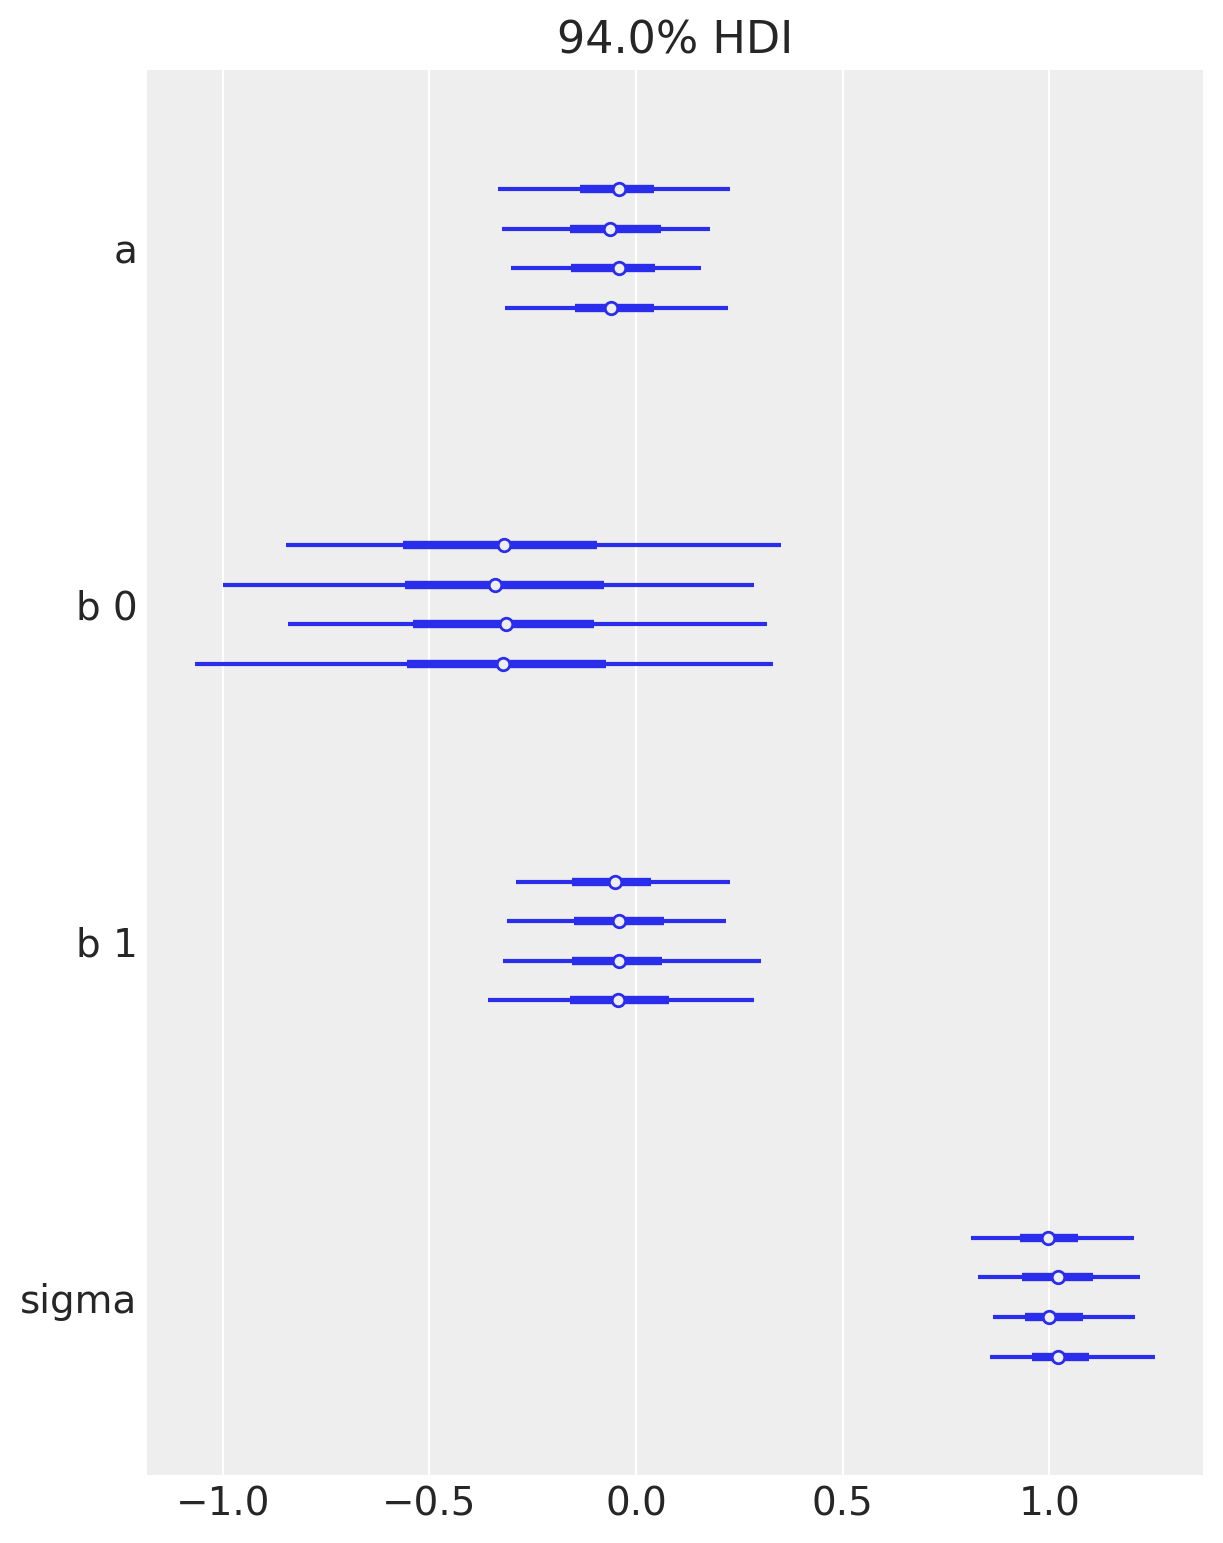

In [39]:
az.plot_forest(sample_age);

Again, the effect sizes of the number of waffle houses on age becomes diminished once we condition on whether the state is in the South or not. This is similar to the last question.

All three problems below are based on the same data. The data in data(foxes) are 116 foxes from
30 different urban groups in England. These foxes are like street gangs. Group size varies from 2 to
8 individuals. Each group maintains its own urban territory. Some territories are larger than others.
The area variable encodes this information. Some territories also have more avgfood than others.
We want to model the weight of each fox. For the problems below, assume the following DAG:


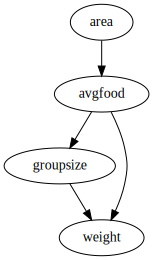

In [40]:
Foxy = CausalGraphicalModel(
    nodes=["area", "avgfood", "groupsize", "weight"],
    edges=[
        ("area", "avgfood"),
        ("avgfood", "groupsize"),
        ("avgfood", "weight"),
        ("groupsize", "weight")
    ]
)

# draw return a graphviz `dot` object, which jupyter can render
Foxy.draw()

In [41]:
foxy = pd.read_csv("./data/foxes.csv", delimiter=";")

### 6H3.

Use a model to infer the total causal influence of area on weight. Would increasing the area
available to each fox make it heavier (healthier)? You might want to standardize the variables. Regardless, use prior predictive simulation to show that your model’s prior predictions stay within the
possible outcome range

#### Answer 
 To find the total causal impact of area on weight, we simply regress weight on area with no conditioning. This is because the effect of area on weight is mediated through the other variables.

In [42]:
foxy.head(2)

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84


In [43]:
# standardise the continuous variables
sf, sa, sw = standardize(foxy.avgfood), standardize(
    foxy.area), standardize(foxy.weight)

In [44]:
# impact of area on weight
with pm.Model() as area_on_weight:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    mu = a + b*sa
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=sw)
    sample = pm.sample(draws=250, chains=4)
    prior_preds = pm.sample_prior_predictive(samples=100, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.


In [45]:
az.summary(sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,0.000,0.084,-0.155,0.150,0.003,0.003,1003.0,448.0,997.0,548.0,1.01
b,0.015,0.096,-0.158,0.200,0.003,0.003,1267.0,481.0,1266.0,705.0,1.00
sigma,1.016,0.075,0.891,1.171,0.002,0.001,1335.0,1303.0,1313.0,460.0,1.00


In [46]:
x = np.linspace(-1, 1)
# posterior samples on lines
post_dist = sample["a"] + np.outer(x, sample["b"])
cred_intervals = pm.hpd(post_dist.T,)  # credibly intervals
post_preds = np.random.normal(loc=post_dist, scale=sample["sigma"])
pred_intervals = pm.hpd(post_preds.T,)  # prediction intervals

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


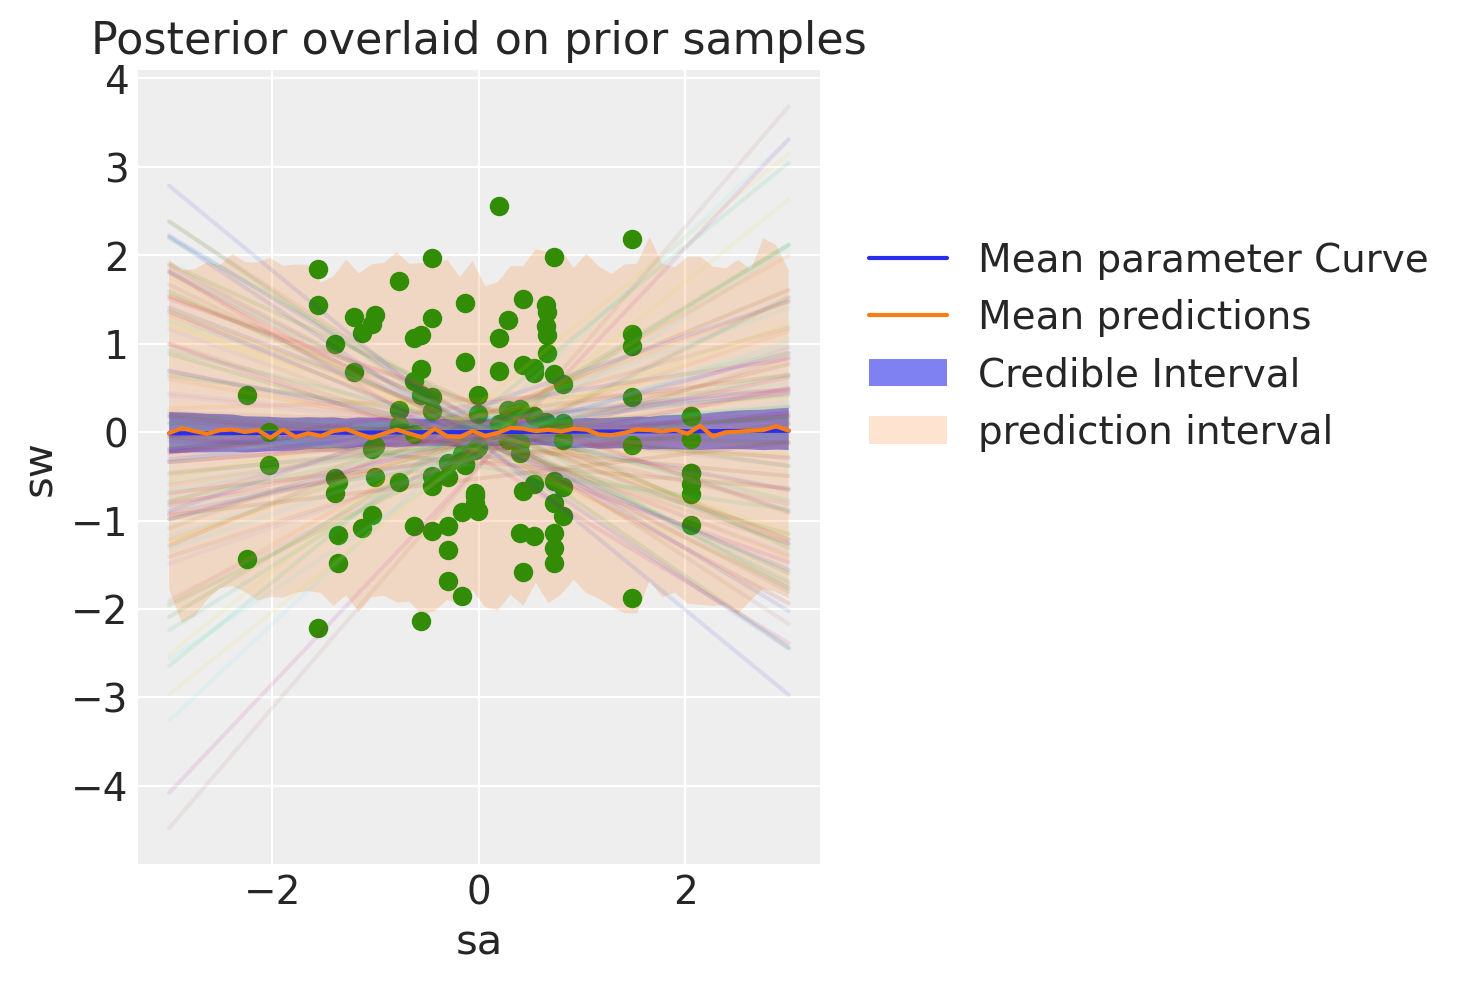

In [47]:
# plot the prior predictive distribution
x = np.linspace(-3, 3)
for a, b in zip(prior_preds["a"], prior_preds["b"]):
    y = a + b*x
    plt.plot(x, y, alpha=0.1)

plt.plot(x, np.mean(post_dist, axis=1), label="Mean parameter Curve")
plt.fill_between(
    x, cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.6, label="Credible Interval")
plt.plot(x, np.mean(post_preds, axis=1), label="Mean predictions")
plt.fill_between(
    x, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2, label="prediction interval")
plt.scatter(sa, sw)
plt.title("Posterior overlaid on prior samples")
plt.xlabel("sa")
plt.ylabel("sw")
plt.legend(loc=(1.05, 0.5));

If there is a total direct effect of area on weight, it's very weak. We don't need to condition on any of the mediating variables between area and weight in this example because there is no back door confounding the original effect.

The posterior prediction intervals for this causal effect seem to be consistent with the data that was actually observed.

### 6H4.
Now infer the causal impact of adding food to a territory. Would this make foxes heavier? Which covariates do you need to adjust for to estimate the total causal influence of food?

#### Answer 
 There are no confounding backdoors between average food and weight in this model. Therefore no adjustments need to be made, and we can simply regress weight onto food without any further complications.


In [48]:
# impact of average food on weight
with pm.Model() as food_on_weight:
    a = pm.Normal("a", mu=0, sd=0.2)
    b = pm.Normal("b", mu=0, sd=0.5)
    mu = a + b*sf
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=sw)
    food_sample = pm.sample(draws=250, chains=4)
    #prior_preds = pm.sample_prior_predictive(samples = 100, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 2 seconds.


In [49]:
x = np.linspace(-2, 2)
# posterior samples on lines
post_dist = food_sample["a"] + np.outer(x, food_sample["b"])
cred_intervals = pm.hpd(post_dist.T,)  # credibly intervals
post_preds = np.random.normal(loc=post_dist, scale=food_sample["sigma"])
pred_intervals = pm.hpd(post_preds.T,)  # prediction intervals

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  warnings.warn(("hpd will be deprecated " "Please replace hdi"),)
/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/stats/stats.py:483: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  warnings.warn(


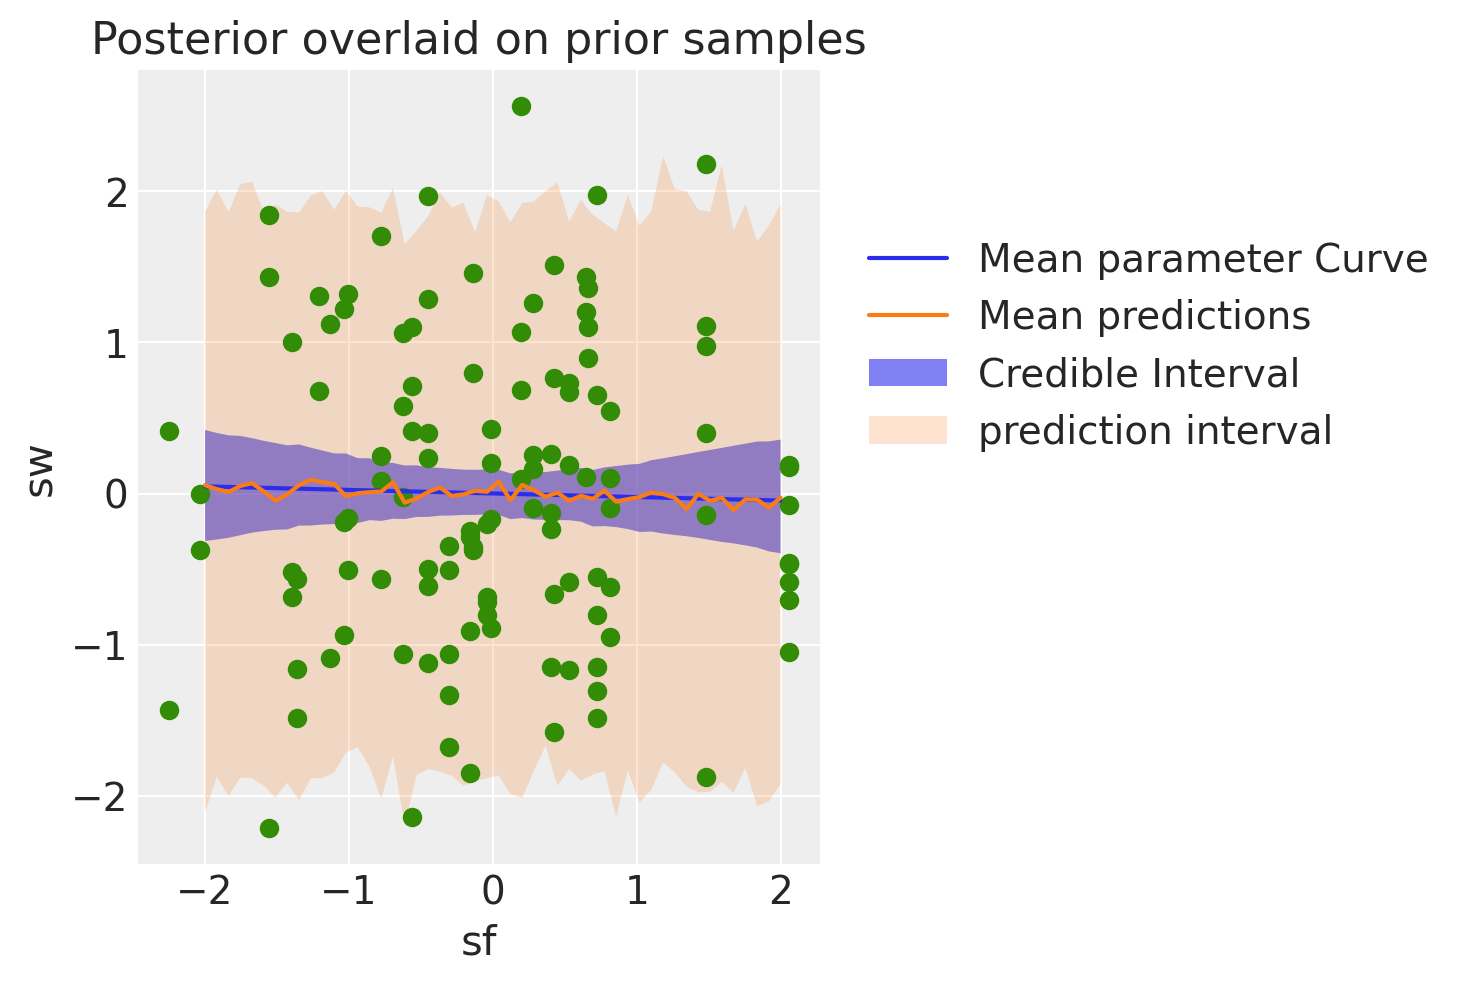

In [50]:
plt.plot(x, np.mean(post_dist, axis=1), label="Mean parameter Curve")
plt.fill_between(
    x, cred_intervals[:, 0], cred_intervals[:, 1], alpha=0.6, label="Credible Interval")
plt.plot(x, np.mean(post_preds, axis=1), label="Mean predictions")
plt.fill_between(
    x, pred_intervals[:, 0], pred_intervals[:, 1], alpha=0.2, label="prediction interval")
plt.scatter(sa, sw)
plt.title("Posterior overlaid on prior samples")
plt.xlabel("sf")
plt.ylabel("sw")
plt.legend(loc=(1.05, 0.5));

Again, the average food appears to have no overall impact. Presumably this is due to a masking effect. This makes intuitive sense. As average food in a territory goes up, so does the group size, which simply means the larger food supply is distributed among more foxes.



### 6H5.
Now infer the causal impact of group size. Which covariates do you need to adjust for? Looking at the posterior distribution of the resulting model, what do you think explains these data? That is, can you explain the estimates for all three problems? How do they go together?

#### Answer

In this case, the effect of groupsize on weight is confounded by the average food in the territory so we need to control for average food in this model.

In [51]:
foxy.groupsize.drop_duplicates().values - 2

array([0, 1, 5, 2, 6, 3, 4])

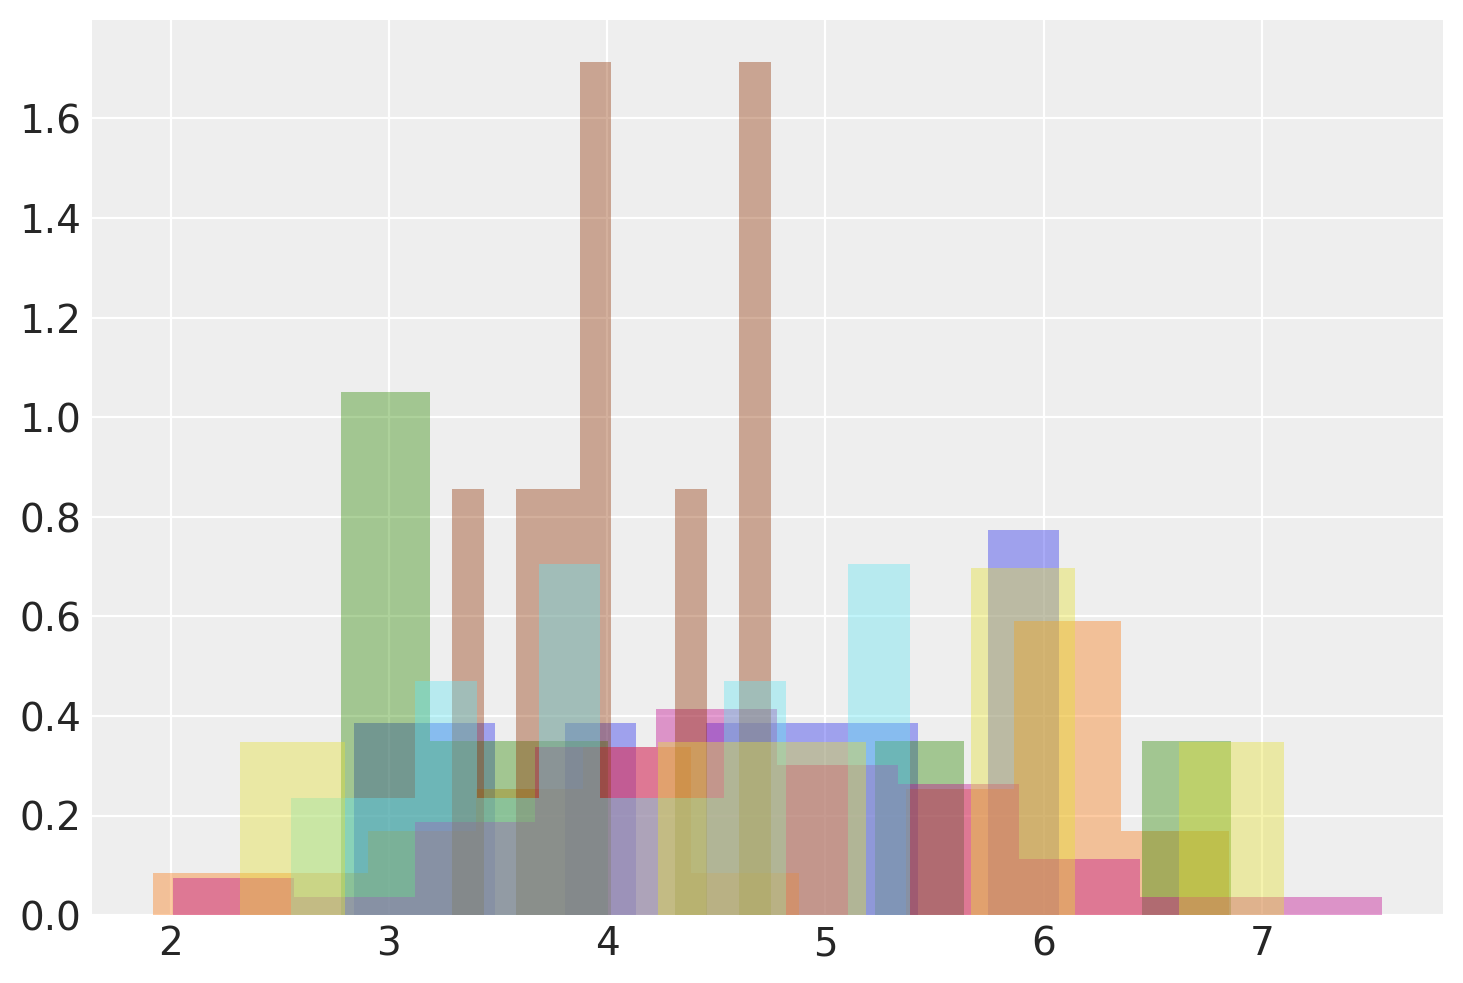

In [52]:
for x in foxy.groupsize.drop_duplicates().values:
    plt.hist(foxy[foxy.groupsize == x].weight, alpha=0.4, density=True)

In [53]:
sg = standardize(foxy.groupsize)

In [54]:
# impact of average food on weight
with pm.Model() as food_group_on_weight:
    a = pm.Normal("a", mu=0, sd=0.2)
    bf = pm.Normal("bf", mu=0, sd=0.5)  # food parameter
    bg = pm.Normal("bg", mu=0, sd=0.5)  # group parameter
    mu = a + bf*sf + bg*sg
    sigma = pm.Exponential("sigma", 1)
    weight = pm.Normal("weight", mu=mu, sd=sigma, observed=sw)
    sample = pm.sample(draws=250, chains=4)
    #prior_preds = pm.sample_prior_predictive(samples = 100, random_seed=42)

Only 250 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bg, bf, a]


Sampling 4 chains for 1_000 tune and 250 draw iterations (4_000 + 1_000 draws total) took 3 seconds.


In [55]:
az.summary(sample)

/home/aidan/anaconda3/envs/pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
a,-0.002,0.080,-0.148,0.148,0.003,0.003,775.0,431.0,791.0,573.0,1.01
bf,0.472,0.181,0.141,0.821,0.007,0.005,635.0,635.0,644.0,559.0,1.00
bg,-0.566,0.187,-0.921,-0.233,0.008,0.005,608.0,608.0,611.0,503.0,1.01
sigma,0.961,0.064,0.834,1.075,0.002,0.002,682.0,682.0,701.0,369.0,1.01


We can see that the group size has a negative effect on the weight of the animals. This makes intuitive sense, as a large group size for a given amount of food means that there are less calories available per wolf, limiting their growth.

Combining the last three questions we make the following conclusions. Area drives up the average food in the area. When the average food increases it increases the weight of foxes when the group size is controlled. However, typically average food would drive up the number of foxes within the group, so now there are more foxes, and the food resources have to be spread more thinly, driving down the weight of the foxes as much as it would be driven up by the availability of food. One could imagine that in groups of foxes that all foxes get their alloted share of food, no matter how much is available. Any residual food is used to drive the population up, rather than support weightier foxes. Typically increasing the area, which in turn drives up average food would just cause the territory to support more foxes, rather than more weighty foxes.

### 6H6.

Consider your own research question. Draw a DAG to represent it. What are the testable
implications of your DAG? Are there any variables you could condition on to close all backdoor
paths? Are there unobserved variables that you have omitted? Would a reasonable colleague imagine
additional threats to causal inference that you have ignored?

#### Answer 
 Too open ended for this notebook

### 6H7.

For the DAG you made in the previous problem, can you write a data generating simulation for
it? Can you design one or more statistical models to produce causal estimates? If so, try to calculate
interesting counterfactuals. If not, use the simulation to estimate the size of the bias you might expect.
Under what conditions would you, for example, infer the opposite of a true causal effect?

#### Answer 
 Ditto

In [56]:
%watermark -n -u -v -iv -w

Last updated: Sun Dec 20 2020

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.18.1

arviz     : 0.9.0
numpy     : 1.19.1
scipy     : 1.5.2
matplotlib: 3.3.2
pymc3     : 3.9.3
pandas    : 1.1.3
seaborn   : 0.11.0

Watermark: 2.1.0

